# STEP 0: PROJECT SETUP
##### The objective of this notebook is to develop a deep learning model from scratch. While we could load existing weights from pre-trained models to achieve a higher prediction accuracy, I'd like to develop a model for images that have not been included on previously trained models, such as ImageNet. 
##### The experience gained developing this model will be used for creating a classifier for vintage postcards to predict the type of postcard based on technical specifications (i.e. real photo, white border era, undivided back, photochrome, etc.), which require extreme zooming into the high-res scans of each image to detect printing patterns, as well as to analyze the full front and back views of each postcard.

### Import libraries:

In [1]:
import os
import random
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.preprocessing import image as im
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from matplotlib import pyplot as plt
%matplotlib inline

from time import time
from winsound import Beep

C:\Users\centli\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Set up local project directory:
##### Keeps code cleaner by setting a default local root folder

In [2]:
os.chdir(os.path.join('E:/', 'DeepLearning', 'dog_breeds'))
print(os.getcwd())

E:\DeepLearning\dog_breeds


# STEP 1: PREPARE LABELS

### Read labels file and display the first and last 5 rows:
##### Here, we make sure that our labels data file was read correctly

In [3]:
labels = pd.read_csv('labels.csv')
display(labels.iloc[np.r_[0:5, -5:0]])

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher
10221,fff43b07992508bc822f33d8ffd902ae,chesapeake_bay_retriever


### Image settings:
##### Here, we set the image size that we want to use for the project. 128x128 is the maximum I was able to run on my GPU, and 256x256 would fail. We keep at 64x64 for computing efficiency.

In [4]:
# target image size (width and height)
w, h = 96, 96

### Split data into Train, Validate and Test sets at random, based on labels data (80:10:10):

In [5]:
# set seed for reproducibility
random.seed(123)

# get list of all image id's in labels data
id_list = [id for id in labels.id]

# percentage assigned to train set (80% of total)
id_list_train = random.sample(id_list, int(np.round(len(id_list) * 0.80)))  

# remove images assigned to train set
id_list = [id for id in id_list if id not in id_list_train]  

# assign half of non-train images to validate set (10% of total)
id_list_validate = random.sample(id_list, int(np.round(len(id_list) * 0.50)))  

# remaining images are test set
id_list_test = [id for id in id_list if id not in id_list_validate]  

print(f"Total:{len(labels)} / Train:{len(id_list_train)} / Validate:{len(id_list_validate)} / Test:{len(id_list_test)}")

Total:10222 / Train:8178 / Validate:1022 / Test:1022


# STEP 2: PREPARE IMAGES

### Resize images and copy them to Train, Validate and Test folders, and into each corresponding classification folder (Optional resizing and data augmentation):
##### While saving augmented images to disk is not necessary for training, it is very educational to be able to see what the augmented images look like. The Train and Validation folders include subfolders with the breed label as their name. For training, each original image has been augmented a few times, as seen in the "augment_size" variable, below. 
##### The Test folder includes just one subfolder without any labels, and images are not augmented.

In [6]:
# to bypass the data augmentation process set "augment_size = 0" 
def process_images(list_src, path_src, path_dst, subfolders, augment_size, img_size, resize):    
    
    augment = im.ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.5,
                        rescale=1/255, zoom_range=(0.9,1.1), horizontal_flip=True, vertical_flip=False, fill_mode='constant')

    for id in list_src:    
        
        if subfolders:                        
            breed = labels[labels.id == id].breed.item()  
        else:
            # no subfolders used
            breed = 'test' 
        
        # make subfolders using breed labels
        if not os.path.exists(f"{path_dst}{breed}"):
            os.makedirs(f"{path_dst}{breed}")
            
        # read and resize images            
        img = cv.imread(f"{path_src}{id}.jpg")  
        if resize:
            img = cv.resize(img, img_size)

        # save original images
        cv.imwrite(f"{path_dst}{breed}/{id}.jpg", img)    

        # save augmented images (optional)
        if augment_size > 0:            
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            x = img.reshape((1,) + img.shape)
            i = 0
            for batch in augment.flow(x, save_to_dir=f"{path_dst}{breed}", save_prefix=f"{id}", save_format='jpg'):
                i += 1
                if i >= augment_size:
                    break         
        
            
print('Image preparation in progress...')

process_images(id_list_train, 'downloaded/train/', 'train/', subfolders=True, augment_size=4, img_size=(w,h), resize=True)
process_images(id_list_validate, 'downloaded/train/', 'validate/', subfolders=True, augment_size=0, img_size=(w,h), resize=True)
process_images(id_list_test, 'downloaded/train/', 'test/', subfolders=False, augment_size=0, img_size=(w,h), resize=True)

print('Image preparation completed successfully')
Beep(500,500)

Image preparation in progress...
Image preparation completed successfully


### Display a few sample images from Train folder:

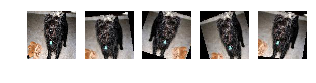

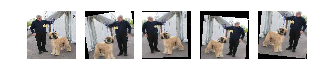

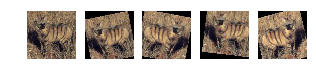

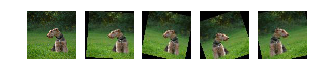

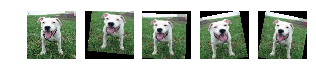

In [7]:
def sample_images(path, num_folders):

    dir_list = os.listdir(path)[0:num_folders]

    for dir in dir_list:     
        prefix = os.listdir(f'{path}{dir}')[0].replace('.jpg', '')    
        img_files = [filename for filename in os.listdir(f'{path}{dir}') if filename.startswith(prefix)]
        tot_img_files = len(img_files)

        fig = plt.figure(figsize=(tot_img_files, tot_img_files))            
        for k in range(0, tot_img_files):    
            fig.add_subplot(1, tot_img_files, k+1)
            plt.imshow(im.load_img(f'{path}{dir}/{img_files[k]}'))
            plt.axis('off')        
            
sample_images('train/', 5)

### Read images into a Pandas dataframe:

In [8]:
def read_files(path):
    list_augmented = [filename for filename in os.listdir(path) if filename.endswith('jpg')]
    return list_augmented


def read_folders(path):
    list_folders = [foldername for foldername in os.listdir(path) if os.path.isdir(f'{path}/{foldername}')]
    return list_folders


def read_augmented_images(path):
    df_labels = pd.DataFrame(columns=['id', 'breed'])    
    folder_labels = read_folders(path)

    for folder in folder_labels:    
        folder_imgs = read_files(f'{path}{folder}')
        for file in folder_imgs:            
            file = file.replace('.jpg', '')
            df_labels = df_labels.append(pd.DataFrame([[file, folder]], columns=['id', 'breed']), ignore_index=True)
            
    return df_labels


def read_test_images(path):
    df_labels = pd.DataFrame(columns=['id', 'breed'])   
    folder_imgs = read_files(path)
    
    for img in folder_imgs:        
        id = img.replace('.jpg', '')
        breed = labels[labels.id == id].breed.item()
        df_labels = df_labels.append(pd.DataFrame([[id, breed]], columns=['id', 'breed']), ignore_index=True)
        
    return df_labels
    

print('Image reading in progress...')

labels_train = read_augmented_images('train/')
labels_validate = read_augmented_images('validate/')
labels_test = read_test_images('test/test/')

print('Image reading in completed successfully...')

Image reading in progress...
Image reading in completed successfully...


### Display head and tail of labels dataframe:

In [9]:
print('TRAIN SET:')
display(labels_train.iloc[np.r_[0:5, -5:0]])

print('VALIDATE SET:')
display(labels_validate.iloc[np.r_[0:5, -5:0]])

print('TEST SET:')
display(labels_test.iloc[np.r_[0:5, -5:0]])

TRAIN SET:


,id,breed
0,01268f0007876a692907bda89468184c,affenpinscher
1,01268f0007876a692907bda89468184c_0_1136,affenpinscher
2,01268f0007876a692907bda89468184c_0_1980,affenpinscher
3,01268f0007876a692907bda89468184c_0_2291,affenpinscher
4,01268f0007876a692907bda89468184c_0_665,affenpinscher
40878,f7627680c56c5d3acc4f7eae93124459,yorkshire_terrier
40879,f7627680c56c5d3acc4f7eae93124459_0_1692,yorkshire_terrier
40880,f7627680c56c5d3acc4f7eae93124459_0_5875,yorkshire_terrier
40881,f7627680c56c5d3acc4f7eae93124459_0_7371,yorkshire_terrier
40882,f7627680c56c5d3acc4f7eae93124459_0_9438,yorkshire_terrier


VALIDATE SET:


,id,breed
0,20430175869defec1722d3432f42ebd7,affenpinscher
1,4cb48a54b94e4c7dcf9798f7cc7f5a92,affenpinscher
2,4d3bb108c92bf340610878d2f257fb30,affenpinscher
3,5176b5065238615f290f522ff376bb0b,affenpinscher
4,6c2a583219893f8c5adc7f604f802a54,affenpinscher
1017,b7a84afcc388d91869ec8bf85cf0449e,yorkshire_terrier
1018,b9b54494a2ed02ea74f0ef26a8cca728,yorkshire_terrier
1019,be9a79b75ab68064bbcecbd4eb4ef959,yorkshire_terrier
1020,d5c742090f2d1bd616784d96a59bf941,yorkshire_terrier
1021,f28c40401e84e41f5aa4c60fea02a575,yorkshire_terrier


TEST SET:


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
2,008b1271ed1addaccf93783b39deab45,doberman
3,00ca18751837cd6a22813f8e221f7819,affenpinscher
4,0161847d5bfae154af084993fa26a1a7,giant_schnauzer
1017,fea60fdd28de5834520134d6dc77a9a2,black-and-tan_coonhound
1018,fee1696ae6725863f84b0da2c05ad892,bull_mastiff
1019,fef9c3ab585ad3f778c549fda42c1856,miniature_schnauzer
1020,ffa6a8d29ce57eb760d0f182abada4bf,english_foxhound
1021,ffbbf7536ba86dcef3f360bda41181b4,weimaraner


# STEP 3: PREPARE AND DEPLOY MODEL

##### We are creating batches of 50 images for training and validation. The batch size for testing is just 1. 
##### We are not running data augmentation at this step, since it has already been run before.

In [10]:
# normalize image pixel data
train_set = im.ImageDataGenerator(rescale=1/255)
validate_set = im.ImageDataGenerator(rescale=1/255)
test_set = im.ImageDataGenerator(rescale=1/255)

train_gen = train_set.flow_from_directory('train', batch_size=100, target_size=(w,h), class_mode='categorical')
validate_gen = train_set.flow_from_directory('validate', batch_size=50, target_size=(w,h), class_mode='categorical')
test_gen = train_set.flow_from_directory('test', batch_size=1, target_size=(w,h), class_mode=None, shuffle=False)

Found 40883 images belonging to 120 classes.
Found 1022 images belonging to 120 classes.
Found 1022 images belonging to 1 classes.


### CNN Model 1:
##### This model is the best attempt using a custom architechture that does not involve transfer learning. This is the best model architecture I was able to create from scratch, after trying several combinations over the course of a couple of weeks.

##### We pass the image size (width and height) as parameters to the model.

In [11]:
def dl_model_1(w, h):
    model = Sequential()
   
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(w, h, 3)))
    model.add(BatchNormalization())            
    model.add(MaxPooling2D(2,2))    
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (7, 7), padding='same', activation='relu'))    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))    

    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))    

    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (7, 7), padding='same', activation='relu'))    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))  

    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))          
    
    model.add(Flatten())
    model.add(Dropout(0.5))
            
    model.add(Dense(128, activation='relu'))    
    model.add(BatchNormalization())    
    
    model.add(Dense(120, activation='softmax'))    
              
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])    
    return model

model_1 = dl_model_1(w, h)

### Model # 1 summary:

In [12]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       401536    
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0         
__________

### Fit the model using GPU:

In [13]:
time0 = time()

# make sure we use our GPU
with tf.device('/gpu:0'):    
    logs_1 = model_1.fit_generator(train_gen, steps_per_epoch=1500, epochs=5, validation_data=validate_gen, validation_steps=50)
    
print('Time elapsed:', time() - time0)    
Beep(500,500)  # beep when done    

Epoch 1/5
1500/1500 [==============================] - 173s 116ms/step - loss: 3.7730 - acc: 0.1353 - val_loss: 3.6610 - val_acc: 0.1595
Epoch 2/5
1500/1500 [==============================] - 169s 113ms/step - loss: 2.3260 - acc: 0.3927 - val_loss: 3.7751 - val_acc: 0.1967
Epoch 3/5
1500/1500 [==============================] - 169s 113ms/step - loss: 1.4233 - acc: 0.5967 - val_loss: 4.0590 - val_acc: 0.2221
Epoch 4/5
1500/1500 [==============================] - 169s 113ms/step - loss: 0.9349 - acc: 0.7214 - val_loss: 4.5084 - val_acc: 0.2104
Epoch 5/5
1500/1500 [==============================] - 169s 113ms/step - loss: 0.6916 - acc: 0.7882 - val_loss: 4.6960 - val_acc: 0.2182
Time elapsed: 851.4162013530731


### Plot model # 1 accuracy and loss:

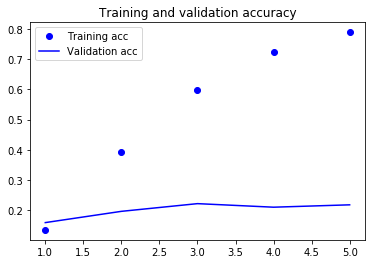

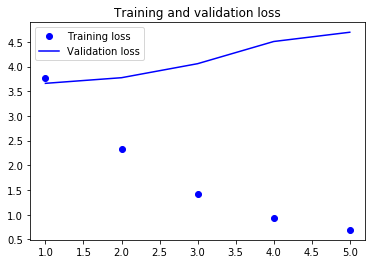

In [14]:
acc = logs_1.history['acc']
val_acc = logs_1.history['val_acc']
loss = logs_1.history['loss']
val_loss = logs_1.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Model # 1 CNN error:

In [15]:
scores = model_1.evaluate_generator(generator=validate_gen, verbose=1)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

21/21 [==============================] - 1s 28ms/step
CNN Error: 78.28%


### Predict test images:
##### # Count predictions where the predicted breed appears in the breeds with the highest probabilities up to the xth term.

In [16]:
test_gen.reset()
predict = model_1.predict_generator(generator=test_gen, verbose=1)

# read breed labels from training
breeds = train_gen.class_indices
breeds = dict((val, key) for key, val in breeds.items())


def getGoodPredictions(x):
    test_labels_good = labels[labels.id.isin(id_list_test)]
    test_labels_good = test_labels_good.reset_index(drop=True)
    test_labels_predicted = []
    n = 0
    for i in range(len(predict)):
        key = np.argpartition(predict[i], -x)[-x:]   
        breed_predicted = [breeds[val] for val in key]

        if test_labels_good['breed'][i] in breed_predicted:
            n += 1
            #print(test_labels_good['id'][i], test_labels_good['breed'][i], breed_predicted)
            
    total_imgs = len(id_list_test)
    percent = round(n / total_imgs * 100, 2)
    if x == 1:
        outcome = print("Good predictions (most likely breed):", n, "out of", total_imgs, "images (", percent, "% )")
    else:
        outcome = print("Good predictions (within", x, "most likely breeds):", n, "out of", total_imgs, "images (", percent, "% )")
    return outcome


# get predictions where the predicted label exists through the 5th most likely breed
for x in range(1, 6):
    getGoodPredictions(x)

1022/1022 [==============================] - 4s 4ms/step
Good predictions (most likely breed): 226 out of 1022 images ( 22.11 % )
Good predictions (within 2 most likely breeds): 332 out of 1022 images ( 32.49 % )
Good predictions (within 3 most likely breeds): 396 out of 1022 images ( 38.75 % )
Good predictions (within 4 most likely breeds): 452 out of 1022 images ( 44.23 % )
Good predictions (within 5 most likely breeds): 500 out of 1022 images ( 48.92 % )


### CNN Model 2:
##### This model is the best attempt using a pre-built architechture (VGG-16) that does not involve transfer learning. This model architecture is commonly used for training on large sets of images. Here, we are using it as a benchmark for comparison against the model I made. The results indicate that while one model may work excellently for a very large set of images, as VGG-16, it may underperform a customized model for a smaller set.
##### We pass the image size (width and height) as parameters to the model.

In [23]:
def dl_model_2(w, h):
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1),input_shape=(w, h, 3)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(120, activation='softmax'))    
              
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])    
    return model

model_2 = dl_model_2(w, h)

### Model # 2 summary:

In [24]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_27 (ZeroPaddi (None, 98, 98, 3)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
zero_padding2d_28 (ZeroPaddi (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
zero_padding2d_29 (ZeroPaddi (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 48, 48, 128)       73856     
__________

### Fit model 2:
##### For comparison, we will use the same number of steps per epoch and validation steps, but since we are using a lower learning rate, the number of epochs is increased from 5 to 10.

In [25]:
time0 = time()

# make sure we use our GPU
with tf.device('/gpu:0'):    
    logs_2 = model_2.fit_generator(train_gen, steps_per_epoch=1500, epochs=10, validation_data=validate_gen, validation_steps=50)
    
print('Time elapsed:', time() - time0)    
Beep(500,500)  # beep when done    

Epoch 1/10
1500/1500 [==============================] - 291s 194ms/step - loss: 4.7783 - acc: 0.0125 - val_loss: 4.7847 - val_acc: 0.0088
Epoch 2/10
1500/1500 [==============================] - 286s 190ms/step - loss: 4.6898 - acc: 0.0176 - val_loss: 4.4091 - val_acc: 0.0372
Epoch 3/10
1500/1500 [==============================] - 285s 190ms/step - loss: 4.0575 - acc: 0.0725 - val_loss: 4.0711 - val_acc: 0.0802
Epoch 4/10
1500/1500 [==============================] - 286s 191ms/step - loss: 3.0764 - acc: 0.2319 - val_loss: 4.4781 - val_acc: 0.1047
Epoch 5/10
1500/1500 [==============================] - 284s 190ms/step - loss: 1.4272 - acc: 0.6073 - val_loss: 6.6708 - val_acc: 0.1086
Epoch 6/10
1500/1500 [==============================] - 285s 190ms/step - loss: 0.4824 - acc: 0.8562 - val_loss: 7.2854 - val_acc: 0.1076
Epoch 7/10
1500/1500 [==============================] - 284s 189ms/step - loss: 0.2441 - acc: 0.9253 - val_loss: 8.0348 - val_acc: 0.1096
Epoch 8/10
1500/1500 [============

### Plot training and validation accuracy:
##### We can see that model 2 is terribly overfit.

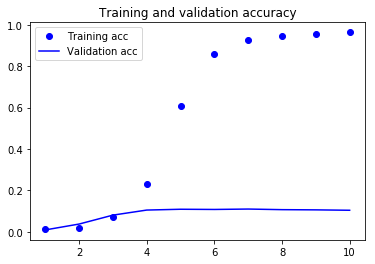

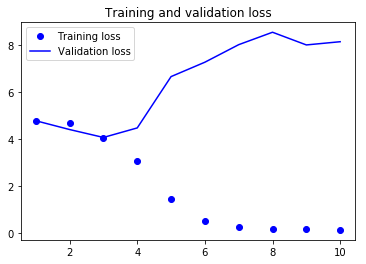

In [26]:
acc = logs_2.history['acc']
val_acc = logs_2.history['val_acc']
loss = logs_2.history['loss']
val_loss = logs_2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Model # 2 CNN error:

In [27]:
scores = model_2.evaluate_generator(generator=validate_gen, verbose=1)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

21/21 [==============================] - 1s 33ms/step
CNN Error: 89.63%


### Predict test images:
##### Count predictions where the predicted breed appears in the breeds with the highest probabilities up to the xth term.

In [28]:
test_gen.reset()
predict = model_2.predict_generator(generator=test_gen, verbose=1)

# read breed labels from training
breeds = train_gen.class_indices
breeds = dict((val, key) for key, val in breeds.items())


def getGoodPredictions(x):
    test_labels_good = labels[labels.id.isin(id_list_test)]
    test_labels_good = test_labels_good.reset_index(drop=True)
    test_labels_predicted = []
    n = 0
    for i in range(len(predict)):
        key = np.argpartition(predict[i], -x)[-x:]   
        breed_predicted = [breeds[val] for val in key]

        if test_labels_good['breed'][i] in breed_predicted:
            n += 1
            #print(test_labels_good['id'][i], test_labels_good['breed'][i], breed_predicted)
            
    total_imgs = len(id_list_test)
    percent = round(n / total_imgs * 100, 2)
    if x == 1:
        outcome = print("Good predictions (most likely breed):", n, "out of", total_imgs, "images (", percent, "% )")
    else:
        outcome = print("Good predictions (within", x, "most likely breeds):", n, "out of", total_imgs, "images (", percent, "% )")
    return outcome


# get predictions where the predicted label exists through the 5th most likely breed
for x in range(1, 6):
    getGoodPredictions(x)

1022/1022 [==============================] - 5s 5ms/step
Good predictions (most likely breed): 114 out of 1022 images ( 11.15 % )
Good predictions (within 2 most likely breeds): 185 out of 1022 images ( 18.1 % )
Good predictions (within 3 most likely breeds): 232 out of 1022 images ( 22.7 % )
Good predictions (within 4 most likely breeds): 273 out of 1022 images ( 26.71 % )
Good predictions (within 5 most likely breeds): 311 out of 1022 images ( 30.43 % )


### Choose and save the best model:

In [29]:
# save the best model to local disk
best_model = model_1
best_model.save('model_dog_breeds.h5')

# STEP 4: PREDICT KAGGLE TEST SET

### Load Kaggle submission images:

In [30]:
# normalize image pixel data
kaggle_set = im.ImageDataGenerator(rescale=1/255)
kaggle_gen = kaggle_set.flow_from_directory('kaggle', batch_size=1, target_size=(w,h), class_mode=None, shuffle=False)

Found 10357 images belonging to 1 classes.


In [31]:
predict = best_model.predict_generator(generator=kaggle_gen, verbose=1)

10357/10357 [==============================] - 39s 4ms/step


### Generate prediction matrix:

In [33]:
# get column names
pred_colnames = list(breeds.values())
pred_colnames.insert(0, 'id')

# make empty pandas dataframe
pred_matrix_kaggle = pd.DataFrame(columns=pred_colnames)

for img in range(0, len(predict)):           
    pred_list = [pred for pred in predict[img]]
    pred_list.insert(0, kaggle_gen.filenames[img].replace('test\\', '').replace('.jpg', ''))
    pred_matrix_kaggle = pred_matrix_kaggle.append(pd.DataFrame([pred_list], columns=pred_colnames), ignore_index=True)    
    
print("Rows in prediction matrix:", len(pred_matrix_kaggle))

# display head and tail of prediction matrix from test set
pred_matrix_kaggle.iloc[np.r_[0:5, -5:0]]

Rows in prediction matrix: 10357


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,1.153486e-07,2.187511e-03,2.114914e-06,2.278581e-09,0.000006,1.199448e-09,1.529291e-09,6.949303e-07,4.468284e-07,...,2.927118e-07,2.727871e-06,6.603009e-07,2.028458e-04,0.000021,4.390430e-04,1.128458e-04,1.905221e-05,1.405319e-03,1.393321e-08
1,00102ee9d8eb90812350685311fe5890,3.011316e-07,1.425934e-07,4.368234e-05,2.601244e-08,0.020034,4.617490e-09,6.704151e-08,1.001233e-06,5.979792e-07,...,1.401668e-07,6.961273e-03,3.443611e-06,7.779727e-03,0.000199,1.373981e-07,4.116205e-04,8.897937e-04,3.327592e-04,3.151624e-09
2,0012a730dfa437f5f3613fb75efcd4ce,1.946644e-06,9.076612e-04,1.560046e-04,5.647730e-05,0.001852,6.372399e-08,1.663197e-05,3.481044e-06,2.860757e-11,...,2.518292e-06,1.100546e-07,3.583698e-08,8.159421e-06,0.000019,1.554130e-06,8.364634e-06,6.283769e-03,5.048546e-03,4.963640e-09
3,001510bc8570bbeee98c8d80c8a95ec1,3.005015e-05,3.571810e-04,3.162294e-04,1.278744e-03,0.004033,7.059815e-05,2.085994e-05,4.554266e-04,5.965147e-03,...,4.713209e-05,5.259010e-06,1.643484e-07,1.281556e-04,0.004175,1.625946e-02,3.201071e-03,2.832899e-02,1.067934e-06,7.384482e-04
4,001a5f3114548acdefa3d4da05474c2e,1.527755e-03,9.017929e-02,5.201908e-05,1.462547e-04,0.001029,5.629034e-06,9.899907e-06,1.607370e-06,3.703065e-07,...,2.937516e-03,1.728219e-06,7.054161e-07,4.267359e-07,0.000099,1.057684e-05,1.023531e-04,1.737692e-05,1.811960e-03,8.863470e-06
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,1.015005e-06,1.713828e-04,1.851055e-07,3.541116e-08,0.000199,1.949444e-09,7.921668e-09,2.731480e-09,8.914045e-10,...,4.205911e-07,4.734044e-09,6.633158e-09,5.857892e-07,0.000227,8.228062e-09,1.195221e-08,1.614768e-06,6.607539e-05,9.918729e-09
10353,fff1ec9e6e413275984966f745a313b0,1.608557e-04,4.021281e-07,3.260495e-05,1.089264e-03,0.000162,1.501896e-06,4.647889e-05,4.876021e-05,1.761894e-05,...,2.125159e-04,1.828193e-03,1.642158e-06,1.040337e-05,0.080084,1.529861e-05,8.578684e-07,1.416361e-01,9.642432e-05,1.263827e-04
10354,fff74b59b758bbbf13a5793182a9bbe4,8.227391e-11,3.555627e-07,6.140327e-07,6.049568e-06,0.000694,1.592801e-06,1.140598e-07,4.453988e-01,2.377453e-02,...,1.490005e-07,3.608882e-05,3.129998e-06,1.228144e-02,0.000010,4.200629e-04,4.799132e-07,1.589803e-04,3.041106e-07,4.101556e-08
10355,fff7d50d848e8014ac1e9172dc6762a3,1.283250e-03,4.835596e-05,2.701849e-06,6.016095e-03,0.000184,9.119680e-08,1.307440e-03,1.121072e-07,6.178310e-06,...,1.028060e-04,6.173384e-05,9.365701e-07,4.524942e-07,0.008996,3.606933e-06,2.763245e-03,7.725565e-07,8.744213e-04,8.503154e-02
10356,fffbff22c1f51e3dc80c4bf04089545b,2.110017e-05,2.516657e-01,2.228085e-07,4.420135e-07,0.000647,3.545423e-08,1.123053e-08,2.496868e-08,1.759690e-08,...,2.461188e-04,1.618414e-05,1.083887e-07,1.974891e-05,0.006691,1.647245e-05,1.349630e-06,1.789089e-05,1.430053e-02,4.402248e-07


### Save predictions as csv file:

In [34]:
pred_matrix_kaggle.to_csv("kaggle_submission_dog_breeds.csv", index=False)

# STEP 5: CONCLUSIONS
##### Developing a model from scratch is a difficult task, which involves a lot of trial and error when choosing the right CNN architecture and hyperparameters. While model 1 allowed us to correctly predict the breed on about 22% of the test images, if we expand our definition of classification to include the 5 five most likely breeds, as we have done in this experiment, we are able to correctly narrow down the actual dog breed  in about half of the predicted images. 
##### Such approach can prove useful when we have breeds, or any other label, where images from different categories look very similar to each other; and the number of labels is relatively large while the number of images for training is relatively low. In this case, we have 120 classes to predict from, but just around 10,000 images to split into train, validate and test sets.
##### To compensate for the small number of images, we added data augmentation to the training process. However, because these augmented images are highly correlated to their parent image, the benefit is not as large as feeding larger sets of independent images.
##### Now, while the model still has a lot of room for improvement, a simple way to quickly glance its usefulness and significance is to calculate the probability of getting 226 successes, at random, out of 1022 trials, with a probability of 1/120 for each try. This can be modeled using a binonial distribution as follows:  binom(x=226, n=1022, p=1/120) = 1.56e-240

In [36]:
from scipy.stats import binom
x, n, p = 226, 1022, 1/120
binom.pmf(x, n, p)

1.5617399347657472e-240

##### Given that the probability of getting 226 successes from 1022 trials, with a probability of 1/120, is almost zero, we can conclude that our model works and it's a step in the right direction. 

##### Finally, some ways to improve the model, that do not involve transfer learning, include:
- Significantly add more images for training
- Increase width and height of the images used (along with better hardware to fit larger-sized images)
- Keep tweaking the model architecture